In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import scipy as sp
import json
import torch
import ase.io as aseio
torch.set_default_dtype(torch.float64)
device="cpu"

from rascaline import SphericalExpansion, SphericalExpansionByPair
from equistore import Labels, TensorBlock, TensorMap
from equistore import operations

from tqdm.notebook import tqdm
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.mp_utils import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix, flatten
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm
import chemiscope

In [3]:
from generate_bispectrum_structures import generate_nu3_degen_structs

# Formal stuff

## $|\overline{\rho_{ii_1i_2i_3}; 00} \rangle$ contains information on signed tetrahedra

## Three columns in the distance matrix (plus "sign" of the tetrahedra) are enough to reconstruct a structure

In [101]:
x = np.random.normal(size=(8,3))

In [130]:
G = x@x.T
d2 = (x**2).sum(axis=1)
D =  d2[np.newaxis,:]+d2[:,np.newaxis]-2*G

In [110]:
dslice = D[:,:3]

In [111]:
dblock = dslice[:3]

In [112]:
ds = dblock.mean(axis=0)

In [118]:
gblock = -(dblock - ds[:,np.newaxis] - ds[np.newaxis,:] + ds.mean())/2

In [128]:
dblock

array([[0.        , 3.00499282, 9.70219465],
       [3.00499282, 0.        , 4.99862414],
       [9.70219465, 4.99862414, 0.        ]])

In [120]:
x[:3] @ x[:3].T

array([[ 1.97097646,  0.33627581, -1.91844966],
       [ 0.33627581,  1.70656798,  0.30113135],
       [-1.91844966,  0.30113135,  3.89431887]])

In [143]:
v, u = np.linalg.eigh(gblock)

In [144]:
x123 = u*np.sqrt(v)
x123 -= x123[0]

In [170]:
def get_point(d, d1, d2, x1, y1, z1, x2, y2, z2):
    # these are the two solutions, courtesy of mathematica, for point zero in the origin and points two and three in x1 and x2 ,,,
    return (
      ( (d*x2*y1**2 - d2*x2*y1**2 + x2**3*y1**2 - x1*y1*y2**3 + d*x2*z1**2 - d2*x2*z1**2 + x2**3*z1**2 - d*x1*z1*z2 + d2*x1*z1*z2 - d*x2*z1*z2 + d1*x2*z1*z2 - x1**2*x2*z1*z2 - x1*x2**2*z1*z2 - x2*y1**2*z1*z2 - x2*z1**3*z2 + d*x1*z2**2 - d1*x1*z2**2 + x1**3*z2**2 + x1*y1**2*z2**2 + x2*y1**2*z2**2 + x1*z1**2*z2**2 + x2*z1**2*z2**2 - x1*z1*z2**3 + y2**2*(d*x1 - d1*x1 + x1**3 + x1*y1**2 + x2*y1**2 + x1*z1**2 + x2*z1**2 - x1*z1*z2) - y1*y2*(-(d2*x1) - d1*x2 + d*(x1 + x2) + x2*(x1*(x1 + x2) + y1**2 + z1**2) + x1*z2**2) - np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))))/(2.*(x2**2*(y1**2 + z1**2) + (y2*z1 - y1*z2)**2 - 2*x1*x2*(y1*y2 + z1*z2) + x1**2*(y2**2 + z2**2))),
        (y2**4*z1*(x1**2 + z1**2) + d*x1*x2*y1**2*z2 - d2*x1*x2*y1**2*z2 - d*x2**2*y1**2*z2 + d1*x2**2*y1**2*z2 - x1**2*x2**2*y1**2*z2 + x1*x2**3*y1**2*z2 - x2**2*y1**4*z2 - x2**2*y1**2*z1**2*z2 + d*y1**2*z1*z2**2 - d2*y1**2*z1*z2**2 + x2**2*y1**2*z1*z2**2 - d*y1**2*z2**3 + d1*y1**2*z2**3 - x1**2*y1**2*z2**3 + x1*x2*y1**2*z2**3 - y1**4*z2**3 - y1**2*z1**2*z2**3 + y1**2*z1*z2**4 - y1*y2**3*(x1*x2*z1 + x1**2*z2 + 2*z1**2*z2) + y2**2*(-(x1*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2))*z1) + (d - d2 + x2*(-x1 + x2))*z1**3 - (-(x1*x2*y1**2) + (d - d1 + x1**2 + y1**2)*z1**2 + z1**4)*z2 + z1*(x1**2 + y1**2 + z1**2)*z2**2) + y1*y2*(x2*z1*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2 + z1**2)) + (x1*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2)) + (-2*d + 2*d2 + (x1 - 2*x2)*x2)*z1**2)*z2 + z1*(2*d - 2*d1 + x1*(2*x1 - x2) + 2*(y1**2 + z1**2))*z2**2 - (x1**2 + 2*z1**2)*z2**3) + x2*z1*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))) - x1*z2*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))))/(2.*(y2*z1 - y1*z2)*(x2**2*(y1**2 + z1**2) + (y2*z1 - y1*z2)**2 - 2*x1*x2*(y1*y2 + z1*z2) + x1**2*(y2**2 + z2**2))),
        (-(y1*y2**4*z1**2) + d*x1*x2*y1*z1*z2 - d2*x1*x2*y1*z1*z2 - d*x2**2*y1*z1*z2 + d1*x2**2*y1*z1*z2 - x1**2*x2**2*y1*z1*z2 + x1*x2**3*y1*z1*z2 - x2**2*y1**3*z1*z2 - x2**2*y1*z1**3*z2 - d*x1**2*y1*z2**2 + d2*x1**2*y1*z2**2 + d*x1*x2*y1*z2**2 - d1*x1*x2*y1*z2**2 + x1**3*x2*y1*z2**2 - x1**2*x2**2*y1*z2**2 - d*y1**3*z2**2 + d2*y1**3*z2**2 + x1*x2*y1**3*z2**2 - x2**2*y1**3*z2**2 + x1*x2*y1*z1**2*z2**2 + x1*x2*y1*z1*z2**3 - x1**2*y1*z2**4 - y1**3*z2**4 + y2**3*z1*(z1*(d - d1 + x1**2 - x1*x2 + y1**2 + z1**2) + (x1**2 + 2*y1**2)*z2) + y1*y2**2*(-((d - d2 + x2**2)*z1**2) + z1*(-2*d + 2*d1 + x1*(-2*x1 + x2) - 2*(y1**2 + z1**2))*z2 - (x1**2 + y1**2 + z1**2)*z2**2) + y2*(x2*z1**2*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2 + z1**2)) - z1*(d2*(x1**2 + 2*y1**2) - d*(x1**2 - x1*x2 + 2*y1**2) + x2*(-(d1*x1) + x1**3 - x1**2*x2 - 2*x2*y1**2 + x1*(y1**2 + z1**2)))*z2 + (y1**2*(d - d1 + x1**2 + y1**2) + (-(x1*x2) + y1**2)*z1**2)*z2**2 + (x1**2 + 2*y1**2)*z1*z2**3) - x2*y1*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))) + x1*y2*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))))/(2.*(y2*z1 - y1*z2)*(x2**2*(y1**2 + z1**2) + (y2*z1 - y1*z2)**2 - 2*x1*x2*(y1*y2 + z1*z2) + x1**2*(y2**2 + z2**2)))
      ),
        ((d*x2*y1**2 - d2*x2*y1**2 + x2**3*y1**2 - x1*y1*y2**3 + d*x2*z1**2 - d2*x2*z1**2 + x2**3*z1**2 - d*x1*z1*z2 + d2*x1*z1*z2 - d*x2*z1*z2 + d1*x2*z1*z2 - x1**2*x2*z1*z2 - x1*x2**2*z1*z2 - x2*y1**2*z1*z2 - x2*z1**3*z2 + d*x1*z2**2 - d1*x1*z2**2 + x1**3*z2**2 + x1*y1**2*z2**2 + x2*y1**2*z2**2 + x1*z1**2*z2**2 + x2*z1**2*z2**2 - x1*z1*z2**3 + y2**2*(d*x1 - d1*x1 + x1**3 + x1*y1**2 + x2*y1**2 + x1*z1**2 + x2*z1**2 - x1*z1*z2) - y1*y2*(-(d2*x1) - d1*x2 + d*(x1 + x2) + x2*(x1*(x1 + x2) + y1**2 + z1**2) + x1*z2**2) + np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))))/(2.*(x2**2*(y1**2 + z1**2) + (y2*z1 - y1*z2)**2 - 2*x1*x2*(y1*y2 + z1*z2) + x1**2*(y2**2 + z2**2))),
        (y2**4*z1*(x1**2 + z1**2) + d*x1*x2*y1**2*z2 - d2*x1*x2*y1**2*z2 - d*x2**2*y1**2*z2 + d1*x2**2*y1**2*z2 - x1**2*x2**2*y1**2*z2 + x1*x2**3*y1**2*z2 - x2**2*y1**4*z2 - x2**2*y1**2*z1**2*z2 + d*y1**2*z1*z2**2 - d2*y1**2*z1*z2**2 + x2**2*y1**2*z1*z2**2 - d*y1**2*z2**3 + d1*y1**2*z2**3 - x1**2*y1**2*z2**3 + x1*x2*y1**2*z2**3 - y1**4*z2**3 - y1**2*z1**2*z2**3 + y1**2*z1*z2**4 - y1*y2**3*(x1*x2*z1 + x1**2*z2 + 2*z1**2*z2) + y2**2*(-(x1*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2))*z1) + (d - d2 + x2*(-x1 + x2))*z1**3 - (-(x1*x2*y1**2) + (d - d1 + x1**2 + y1**2)*z1**2 + z1**4)*z2 + z1*(x1**2 + y1**2 + z1**2)*z2**2) + y1*y2*(x2*z1*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2 + z1**2)) + (x1*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2)) + (-2*d + 2*d2 + (x1 - 2*x2)*x2)*z1**2)*z2 + z1*(2*d - 2*d1 + x1*(2*x1 - x2) + 2*(y1**2 + z1**2))*z2**2 - (x1**2 + 2*z1**2)*z2**3) - x2*z1*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))) + x1*z2*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))))/(2.*(y2*z1 - y1*z2)*(x2**2*(y1**2 + z1**2) + (y2*z1 - y1*z2)**2 - 2*x1*x2*(y1*y2 + z1*z2) + x1**2*(y2**2 + z2**2))),
        (-(y1*y2**4*z1**2) + d*x1*x2*y1*z1*z2 - d2*x1*x2*y1*z1*z2 - d*x2**2*y1*z1*z2 + d1*x2**2*y1*z1*z2 - x1**2*x2**2*y1*z1*z2 + x1*x2**3*y1*z1*z2 - x2**2*y1**3*z1*z2 - x2**2*y1*z1**3*z2 - d*x1**2*y1*z2**2 + d2*x1**2*y1*z2**2 + d*x1*x2*y1*z2**2 - d1*x1*x2*y1*z2**2 + x1**3*x2*y1*z2**2 - x1**2*x2**2*y1*z2**2 - d*y1**3*z2**2 + d2*y1**3*z2**2 + x1*x2*y1**3*z2**2 - x2**2*y1**3*z2**2 + x1*x2*y1*z1**2*z2**2 + x1*x2*y1*z1*z2**3 - x1**2*y1*z2**4 - y1**3*z2**4 + y2**3*z1*(z1*(d - d1 + x1**2 - x1*x2 + y1**2 + z1**2) + (x1**2 + 2*y1**2)*z2) + y1*y2**2*(-((d - d2 + x2**2)*z1**2) + z1*(-2*d + 2*d1 + x1*(-2*x1 + x2) - 2*(y1**2 + z1**2))*z2 - (x1**2 + y1**2 + z1**2)*z2**2) + y2*(x2*z1**2*(d2*x1 + d*(-x1 + x2) + x2*(-d1 + x1**2 - x1*x2 + y1**2 + z1**2)) - z1*(d2*(x1**2 + 2*y1**2) - d*(x1**2 - x1*x2 + 2*y1**2) + x2*(-(d1*x1) + x1**3 - x1**2*x2 - 2*x2*y1**2 + x1*(y1**2 + z1**2)))*z2 + (y1**2*(d - d1 + x1**2 + y1**2) + (-(x1*x2) + y1**2)*z1**2)*z2**2 + (x1**2 + 2*y1**2)*z1*z2**3) + x2*y1*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))) - x1*y2*np.sqrt(-((y2*z1 - y1*z2)**2*(d2**2*(x1**2 + y1**2 + z1**2) + d**2*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*d2*(x1*x2 + y1*y2 + z1*z2) + 2*d2*(x1**2 + y1**2 + z1**2)*((x1 - x2)*x2 + (y1 - y2)*y2 + (z1 - z2)*z2) + (x2**2 + y2**2 + z2**2)*(d1**2 + (x1**2 + y1**2 + z1**2)*((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2) - 2*d1*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2)) - 2*d*(d2*(x1**2 - x1*x2 + y1**2 - y1*y2 + z1**2 - z1*z2) + ((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)*(x1*x2 + y1*y2 + z1*z2) + d1*(-(x1*x2) + x2**2 - y1*y2 + y2**2 - z1*z2 + z2**2))))))/(2.*(y2*z1 - y1*z2)*(x2**2*(y1**2 + z1**2) + (y2*z1 - y1*z2)**2 - 2*x1*x2*(y1*y2 + z1*z2) + x1**2*(y2**2 + z2**2)))
      )        
    )

In [145]:
x123[0]

array([0., 0., 0.])

In [177]:
x4 = get_point(*dslice[4], *x123[1], *x123[2])[1]

In [178]:
x123_2 = (x123**2).sum(axis=1)
x123_2[np.newaxis,:]+x123_2[:,np.newaxis]-2*x123@x123.T 

array([[0.00000000e+00, 3.00499282e+00, 9.70219465e+00],
       [3.00499282e+00, 8.88178420e-16, 4.99862414e+00],
       [9.70219465e+00, 4.99862414e+00, 0.00000000e+00]])

In [179]:
dslice[:8]

array([[ 0.        ,  3.00499282,  9.70219465],
       [ 3.00499282,  0.        ,  4.99862414],
       [ 9.70219465,  4.99862414,  0.        ],
       [ 0.49650506,  5.61413442, 12.83999347],
       [ 2.09319481,  4.36996732,  6.55377846],
       [ 0.48967531,  2.61896744,  7.02150939],
       [ 7.9271811 ,  3.00056658, 14.59322356],
       [ 1.10368855,  2.18249893,  5.34374775]])

In [180]:
x1234 = np.vstack([x123,x4])
x1234_2 = (x1234**2).sum(axis=1)
x1234_2[np.newaxis,:]+x1234_2[:,np.newaxis]-2*x1234@x1234.T 

array([[0.00000000e+00, 3.00499282e+00, 9.70219465e+00, 2.09319481e+00],
       [3.00499282e+00, 8.88178420e-16, 4.99862414e+00, 4.36996732e+00],
       [9.70219465e+00, 4.99862414e+00, 0.00000000e+00, 6.55377846e+00],
       [2.09319481e+00, 4.36996732e+00, 6.55377846e+00, 0.00000000e+00]])

# Generates a bunch of degenerate pairs - closer or farther from being actually symmetric

### Random Boron clusters

In [14]:
np.random.seed(12345)
ngen = 1000
frames = []
for f in tqdm.tqdm(range(ngen)):
    for i in range(10000):
        r = np.random.uniform(0.5,2)
        z1 = np.random.uniform(0.5,2)
        z2 = np.random.uniform(1.5,1.8)
        psi = np.random.uniform(0,np.pi)
        phi1 = np.random.uniform(np.pi/6, np.pi)
        phi2 = np.random.uniform(np.pi/6, np.pi)
        fr = generate_nu3_degen_structs(r, [0, phi1, phi1+phi2], 
                                   psi, z1, z2, "B", "B", "B")
        dist = fr[0].get_all_distances()
        if dist[0,1:].min()>1.5 and dist[0,1:].max()<1.8 and dist[np.triu_indices(len(dist),1)].flatten().min()>1.2:
            fr[0].info["pars"] = str((f, "+")+(r, z1, z2, psi, phi1, phi2))
            fr[1].info["pars"] = str((f, "-")+(r, z1, z2, psi, phi1, phi2))
            break
    if (i>9990):
        print("oops!")
    frames += fr

In [15]:
cs = chemiscope.show(frames=frames, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

In [11]:
frames[134*2].info

{'pars': "(134, '+', 1.4825871197970235, 0.8846158597485543, 1.7298751760678024, 2.7704036169017265, 1.974960780990969, 2.2043863540648965)"}

In [12]:
aseio.write("/tmp/b8.xyz", frames)

### Mg clusters

In [4]:
frames_mg = []
n1, n2, n3 = 8,8,8
for psi in np.linspace(np.pi/6, np.pi*5/6, n1):
    for dphi1 in np.linspace(np.pi*2/3 - 1.2, np.pi*2/3+0.4, n2):
        for dphi2 in np.linspace(np.pi*2/3-0.7, np.pi*2/3+1.3, n3):
            frames_mg += generate_nu3_degen_structs(2, [0, dphi1, dphi1+dphi2], 
                           psi, 1, np.sqrt(5), "Mg", "Mg", "Mg")

In [5]:
# shuffles keeping pairs together for easier analysis
idx = np.asarray(range(len(frames_mg)//2), dtype=int)
np.random.shuffle(idx)
nfr = []
for i in idx:
    nfr.append(frames_mg[2*i])
    nfr.append(frames_mg[2*i+1])
frames_mg = nfr

In [58]:
cs = chemiscope.show(frames=frames_mg, mode="structure", settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

StructureWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": t…

In [66]:
aseio.write("/tmp/mg8.xyz", frames_mg)

# Compute raw expansion coefficients

In [177]:
hypers = {
    "cutoff": 2.5,
    "max_radial": 2,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)

# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
for b in rho1i.blocks():
    b.values[:]/=norm_rho1

/home/michele/local/lib/python3.8/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [178]:
rho1i

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center']
           1             1                    0                   5
           1             1                    1                   5
           1             1                    2                   5
           1             1                    3                   5

In [179]:
rho1i.block(0)

TensorBlock
    samples: ['structure', 'center']
    component: ['spherical_harmonics_m']
    properties: ['species_neighbor_1', 'n_1']
    gradients: no

In [180]:
calculator = SphericalExpansionByPair(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
for b in gij.blocks():
    b.values[:]/=norm_rho1

In [181]:
gij

TensorMap with 4 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor']
           1             1                    0                   5                5
           1             1                    1                   5                5
           1             1                    2                   5                5
           1             1                    3                   5                5

In [182]:
gij.block(0)

TensorBlock
    samples: ['structure', 'center', 'neighbor']
    component: ['spherical_harmonics_m']
    properties: ['n_1']
    gradients: no

## Test there is consistency at the level of rhoij and gij

In [183]:
test = operations.sum_over_samples(gij, samples_names=["neighbor"]) 

In [184]:
test.block(1).values;

In [185]:
np.linalg.norm(rho1i.block(1).values/test.block(1).values -1)

2.4600748568961446e-12

# Now compute the correlation stuff!

In [186]:
cg = ClebschGordanReal(5)

## pair features

In [187]:
%%time
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)

CPU times: user 42.3 s, sys: 6.41 s, total: 48.8 s
Wall time: 1min 36s


In [199]:
%%time 
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)

CPU times: user 16.3 s, sys: 7.1 s, total: 23.4 s
Wall time: 23.4 s


### sanity checks

In [189]:
# nb: we disable lexicographic sorting of L to have comparable feature layout
rho2i_full = cg_combine(rho1i, rho1i, clebsch_gordan=cg, lcut=3, sorted_l=False)
test = operations.sum_over_samples(rhoii1i2_nu0, samples_names=["neighbor_1", "neighbor_2"]) 

In [190]:
np.linalg.norm(rho2i_full.block(2).values/test.block(2).values-1)

2.116282603547629e-09

## higher-order 

In [200]:
%%time
# here we use all tricks to reduce cost
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3)
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=3)
rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3)
rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0)

CPU times: user 21 s, sys: 6.93 s, total: 27.9 s
Wall time: 28 s


In [192]:
%%time 
#rho5il1 = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=1)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs


In [193]:
%time 
#rho6il1 = cg_increment(rho5il1, rho1i, clebsch_gordan=cg, lcut=1)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 13.1 µs


In [194]:
%time 
#rho7i = cg_increment(rho6il1, rho1i, clebsch_gordan=cg, lcut=0, filter_sigma=[1])

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 14.1 µs


Since we have a LOT of features and few structures, we use PCA to reduce the number of features with no information loss

In [203]:
from sklearn.decomposition import PCA

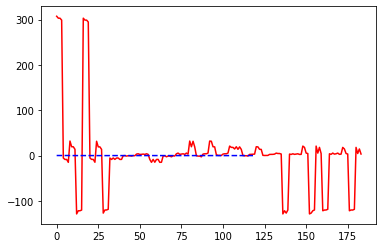

In [204]:
plt.plot(rhoii1i2_nu1.block(0).values.squeeze()[:64].sum(axis=0)*2e3,'r-')
plt.plot(rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze()[0], 'b--')

In [201]:
rhoii1i2_nu1

TensorMap with 2 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor_a' 'species_neighbor_b']
           3             1                    0                   5                 5                   5
           3            -1                    0                   5                 5                   5

In [234]:
triplet_samples = rhoii1i2_nu1.block(0).samples
raw = np.hstack([rhoii1i2_nu1.block(0).values.squeeze(), rhoii1i2_nu1.block(1).values.squeeze()])
feats_n2nu1 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw))
feats_n2nu1 /= np.sqrt((feats_n2nu1**2).sum(axis=1).mean())

In [206]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu123 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

In [208]:
raw = np.hstack([
    rho1i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho2i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho3i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho4i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=1,spherical_harmonics_l=0).values.squeeze(),
    rho5i.block(inversion_sigma=-1,spherical_harmonics_l=0).values.squeeze()
])
feats_nu12345 = torch.tensor(PCA(n_components=min(raw.shape[0],raw.shape[-1])).fit_transform(raw) / np.sqrt((raw**2).sum(axis=1).mean()))

tensor(38)


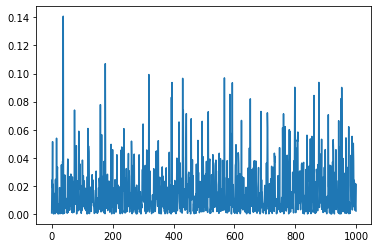

In [209]:
deltas = np.sqrt(((feats_nu12345[::2]-feats_nu12345[1::2])**2).sum(axis=1))/np.sqrt(((feats_nu12345[::2]+feats_nu12345[1::2])**2).sum(axis=1))
plt.plot(deltas )
print(deltas.argmax())

In [210]:
cs = chemiscope.show(frames=frames, properties = { 
 "feats12345":    feats_nu12345[:,:8].numpy(),
 "type" : [i%2 for i in range(len(frames))],
 "deltas" : [deltas[i//2]   for i in range(len(frames)) ],
 "pars" : [f.info["pars"] for f in frames]   
}
                     , settings = {'structure': [{
   'axes': 'xyz',
   'keepOrientation': True,
   'playbackDelay': 250}]})
display(cs)

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"axes": "xyz", "keepOrientation": …

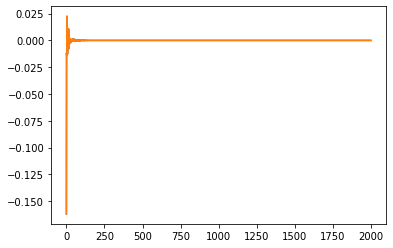

In [201]:
plt.plot(feats_nu12345[14])
plt.plot(feats_nu12345[15])

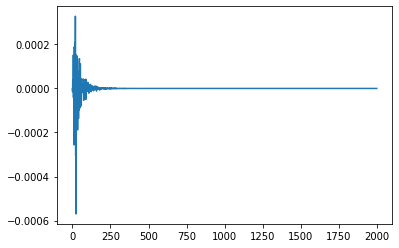

In [206]:
plt.plot(feats_nu12345[220]-feats_nu12345[221])

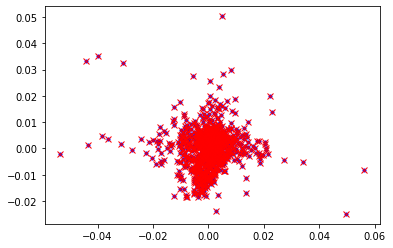

In [203]:
plt.plot(feats_nu123[::2,7], feats_nu123[::2,8], 'b.')
plt.plot(feats_nu123[1::2,7], feats_nu123[1::2,8], 'rx')

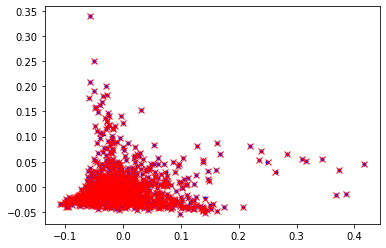

In [204]:
plt.plot(feats_nu12345[::2,2], feats_nu12345[::2,3], 'b.')
plt.plot(feats_nu12345[1::2,2], feats_nu12345[1::2,3], 'rx')

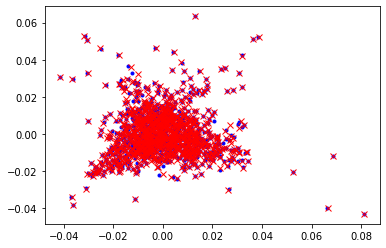

In [211]:
plt.plot(feats_nu12345[::2,8], feats_nu12345[::2,9], 'b.')
plt.plot(feats_nu12345[1::2,8], feats_nu12345[1::2,9], 'rx')

# Now we make an autoencoder thingie

In [212]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

In [213]:
class LinearEncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.layer_size = layer_size 
        self.feat_size = feat_size
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )
    
    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [261]:
class EncodeDecode(torch.nn.Module):
    def __init__(self, layer_size=100, feat_size=32, output_size=32):
        super().__init__()

        self.nn_encode = None
        self.nn_decode = None
        self.feat_size = feat_size
        self.layer_size = layer_size        
        self.output_size= output_size        

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn_encode = torch.nn.Sequential(
            
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.feat_size))
        self.nn_decode = torch.nn.Sequential(
            torch.nn.Linear(self.feat_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.GroupNorm(4,self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.output_size),            
        )

    def feats(self, block, samples):
        tensor = block

        structure_map, new_samples, _ = StructureMap(
            samples, "cpu"
        )
        
        nn_per_triple = self.nn_encode(tensor)
        nn_per_structure = torch.zeros((len(new_samples), nn_per_triple.shape[-1]), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        return nn_per_structure
        
    def forward(self, block, samples):
        if self.nn_encode is None:
            raise Exception("call initialize_weights first")

        outputs = self.nn_decode(self.feats(block, samples))
        return outputs

In [241]:
feats_n2nu1.shape

torch.Size([128000, 272])

In [240]:
feats_nu12345.shape

torch.Size([2000, 2000])

In [216]:
target = feats_nu12345[:,:128]

In [217]:
mymodel = LinearEncodeDecode(32, 16, target.shape[-1])

In [262]:
mymodel = EncodeDecode(32, 16, target.shape[-1])

In [263]:
mymodel.initialize_model_weights(feats_n2nu1, seed=12345)

In [264]:
def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

In [265]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

In [ ]:
n_epochs = 1000
ntrain = 512
ntriples = 64
for epoch in range(0, n_epochs):
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(feats_n2nu1[:ntrain*ntriples], triplet_samples["structure"][:ntrain*ntriples])
        loss += loss_mse(predicted, target[:ntrain])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
    predicted = mymodel(feats_n2nu1[ntrain*ntriples:], triplet_samples["structure"][ntrain*ntriples:])
    
    if epoch % 10 ==0:
        print("Epoch:", epoch, "Energy RMSE: train ", np.sqrt(loss.detach().numpy().flatten()[0]/ntrain),
         "test", np.sqrt(loss_mse(predicted, target[ntrain:]).detach().numpy().flatten()[0]/ (len(frames)-ntrain)) )

Epoch: 0 Energy RMSE: train  4.5950490728725235 test 0.42865146374406127
Epoch: 10 Energy RMSE: train  0.12596040106867704 test 0.11597176670141297
Epoch: 20 Energy RMSE: train  0.10192776721825056 test 0.10259507365490016
Epoch: 30 Energy RMSE: train  0.08537378682153891 test 0.08133189908427337
Epoch: 40 Energy RMSE: train  0.07672766147951356 test 0.07332721778460509
Epoch: 50 Energy RMSE: train  0.07444626342918952 test 0.07106679909664798
Epoch: 60 Energy RMSE: train  0.07390185685114697 test 0.07068333847599634
Epoch: 70 Energy RMSE: train  0.0736004976278869 test 0.07070023932266864


In [254]:
predicted = mymodel(feats_n2nu1, triplet_samples["structure"])
feats = mymodel.feats(feats_n2nu1, triplet_samples["structure"])

In [255]:
np.linalg.norm((predicted[:ntrain]-target[:ntrain]).detach() )/(
    np.linalg.norm(target[:ntrain]) )

0.32374980099183

In [256]:
np.linalg.norm((((predicted[:ntrain:2]+predicted[1:ntrain:2])/2) - ((target[:ntrain:2]+target[1:ntrain:2])/2)).detach() )/(
    np.linalg.norm(target[:ntrain]) )

0.22860545864435322

In [257]:
np.linalg.norm((((predicted[ntrain::2]+predicted[ntrain+1::2])/2) - ((target[ntrain::2]+target[ntrain+1::2])/2)).detach() ) / (
    np.linalg.norm(target[:ntrain]) )

0.37577183976319434

In [258]:
np.linalg.norm((((predicted[:ntrain:2]-predicted[1:ntrain:2])) - ((target[:ntrain:2]-target[1:ntrain:2]))).detach() )/ (
    np.linalg.norm(target[:ntrain:2]-target[1:ntrain:2]))

1.0002315252737808

In [259]:
np.linalg.norm((((predicted[ntrain::2]-predicted[1+ntrain::2])) - 
                ((target[ntrain::2]-target[ntrain+1::2]))).detach() )/ (
    np.linalg.norm(target[ntrain::2]-target[1+ntrain::2]))

1.0002433268973103

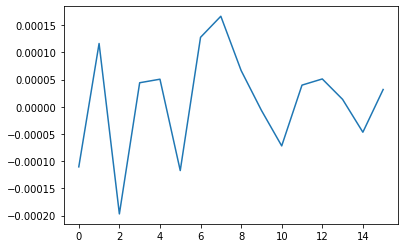

In [260]:
plt.plot(feats[30].detach()-feats[31].detach())

tensor(835)


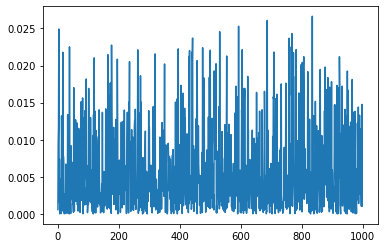

In [230]:
plt.plot(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)))
print(np.sqrt(((target[::2]-target[1::2])**2).sum(axis=1)).argmax())

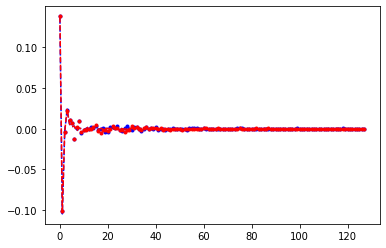

In [231]:
iframe = 72
plt.plot(predicted[iframe].detach(),'b--')
plt.plot(target[iframe].detach(),'b.')
plt.plot(predicted[iframe+1].detach(), 'r--')
plt.plot(target[iframe+1].detach(), 'r.')

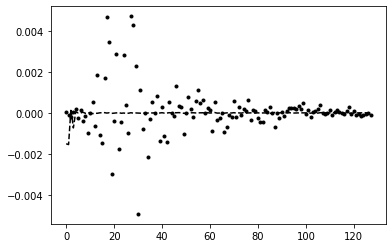

In [232]:
plt.plot((predicted[iframe].detach()-predicted[iframe+1].detach()),'k--')
plt.plot(target[iframe].detach()-target[iframe+1].detach(), 'k.')

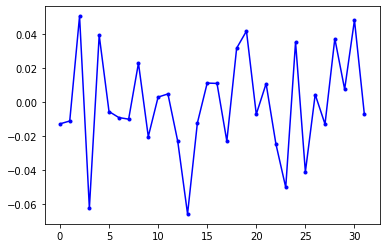

In [129]:
plt.plot((feats[iframe].detach()-feats[iframe+1].detach()),'b.-')